# W207 - Final Project
## Scott Abramson, Brett Brandom, Maria Jose Healey, Yidai Yao

### <span style="color:chocolate"> Pawpularity:predicting engagement with a pet's profile based on the photograph for that profile.  </span>

#### ``Objective``

TBD

#### ``Introduction``

TBD

#### ``Data``

TBD

### Step 1: Import libraries

In [313]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

import os 
import cv2
import glob


### Step 2: Read and Preprocess Data

In [8]:
# load images
path = 'C:\\Users\\maggi\\OneDrive\\Desktop\\DataSci-207\\Final Project\\'

train_images = os.listdir('C:\\Users\\maggi\\OneDrive\\Desktop\\DataSci-207\\Final Project\\train')
train_df = pd.read_csv(path + 'train.csv')
train_df = train_df.set_index('Id')
file_names = []
labels = []
for index in train_df.index:
    file_name = 'C:\\Users\\maggi\\OneDrive\\Desktop\\DataSci-207\\Final Project\\train\\' + index + '.jpg'
    label = train_df.loc[index]['Pawpularity']
    file_names.append(file_name)
    labels.append(label/1.0)
    
train_files, val_files, labels_train, labels_val = train_test_split(file_names, labels, test_size=0.2, random_state=137)

def process_file_names(file_name, label):
    image_string = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(image_string, channels=3)
    img = tf.image.resize(img, [224,224])
    return img, label/100.01
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, labels_train))
train_dataset = train_dataset.map(process_file_names)
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, labels_val))
val_dataset = val_dataset.map(process_file_names)



In [9]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(32)
    return ds
    
train_dataset = configure_for_performance(train_dataset)
val_dataset = configure_for_performance(val_dataset)


In [26]:
train_tuples=list(train_dataset.as_numpy_iterator()) # tuples - batch of images, and respective batch of labels
print(train_tuples[0]) # first batch
print(len(train_tuples[0])) # 2
print(len(train_tuples)) # number of batches

(array([[[[181.89285  , 148.89285  ,  77.89286  ],
         [182.       , 149.       ,  78.       ],
         [179.53572  , 146.53572  ,  75.53571  ],
         ...,
         [164.72002  , 148.84932  ,  79.32398  ],
         [ 32.67352  ,  32.76554  ,  15.614187 ],
         [129.48886  , 105.06815  ,  61.03106  ]],

        [[181.89285  , 148.89285  ,  77.89286  ],
         [182.       , 149.       ,  78.       ],
         [179.53572  , 146.53572  ,  75.53571  ],
         ...,
         [169.061    , 149.73138  ,  77.55818  ],
         [ 73.37938  ,  67.116714 ,  42.85309  ],
         [ 67.7438   ,  54.588226 ,  13.788245 ]],

        [[182.       , 149.       ,  78.       ],
         [182.       , 149.       ,  78.       ],
         [181.46428  , 148.46428  ,  77.46429  ],
         ...,
         [162.8145   , 141.30147  ,  65.63118  ],
         [122.51066  , 107.58455  ,  73.15247  ],
         [ 46.03816  ,  46.160366 ,  13.880543 ]],

        ...,

        [[194.89026  , 191.8673   , 1

In [49]:
print(train_tuples[100][0].shape) # batch m - images (n,224,224,3)
print(len(train_tuples[0][0])) # n
print(len(train_tuples[0][1].shape)) # labels vector
print(len(train_tuples[0][1])) 
print(train_tuples[0][1]) # batch m - labels

(32, 224, 224, 3)
32
1
32
[0.87991201 0.279972   0.279972   0.69993001 0.78992101 0.369963
 0.419958   0.80991901 0.52994701 0.269973   0.99990001 0.70992901
 0.219978   0.259974   0.99990001 0.419958   0.39996    0.239976
 0.229977   0.229977   0.289971   0.29997    0.169983   0.50994901
 0.359964   0.289971   0.239976   0.279972   0.209979   0.329967
 0.459954   0.319968  ]


In [102]:
val_tuples=list(val_dataset.as_numpy_iterator()) # tuples - batch of images, and respective batch of labels
print(val_tuples[0]) # first batch
print(len(val_tuples[0])) # 2
print(len(val_tuples)) # number of batches

(array([[[[ 35.97098  ,  26.970982 ,  27.970982 ],
         [ 12.767858 ,   6.7678576,   8.767858 ],
         [ 16.       ,  11.       ,  15.035715 ],
         ...,
         [ 56.203125 ,  23.203125 ,  30.203125 ],
         [ 52.203125 ,  23.381836 ,  36.560547 ],
         [ 55.006714 ,  27.006714 ,  41.006714 ]],

        [[ 35.492466 ,  26.492466 ,  28.120256 ],
         [ 13.589286 ,   7.589286 ,  10.370536 ],
         [ 16.006975 ,  11.006975 ,  15.809989 ],
         ...,
         [ 49.21875  ,  18.21875  ,  24.21875  ],
         [ 49.02002  ,  20.19873  ,  33.37744  ],
         [ 50.412964 ,  22.412964 ,  36.412964 ]],

        [[ 41.545483 ,  32.545483 ,  35.53934  ],
         [ 14.       ,   8.       ,  12.       ],
         [ 16.017857 ,  11.017858 ,  17.035437 ],
         ...,
         [ 46.015625 ,  16.984375 ,  22.       ],
         [ 47.984375 ,  20.388603 ,  31.194336 ],
         [ 49.       ,  21.       ,  33.03125  ]],

        ...,

        [[ 76.53906  ,  34.11914  ,  

In [104]:
print(val_tuples[60][0].shape) # batch m - images (n,224,224,3)
print(len(val_tuples[0][0])) # n
print(len(val_tuples[0][1].shape)) # labels vector
print(len(val_tuples[0][1])) 
print(val_tuples[0][1]) # batch m - labels

(32, 224, 224, 3)
32
1
32
[0.259974   0.039996   0.289971   0.179982   0.139986   0.65993401
 0.239976   0.359964   0.249975   0.319968   0.249975   0.76992301
 0.359964   0.52994701 0.479952   0.49995    0.129987   0.279972
 0.369963   0.49995    0.249975   0.57994201 0.039996   0.239976
 0.169983   0.489951   0.62993701 0.219978   0.129987   0.259974
 0.339966   0.289971  ]


In [307]:
# Tabular data
train_df = pd.read_csv(path + 'train.csv')
train_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


### Step 3: EDA

In [314]:
# load images
cv_images = []
# the glob module is used to retrieve files/pathnames matching a specified pattern.
for image in glob.glob("C:\\Users\\maggi\\OneDrive\\Desktop\\DataSci-207\\Final Project\\train\\*.jpg"):
    img= cv2.imread(image) # loads an image from the specified file
    cv_images.append(img)


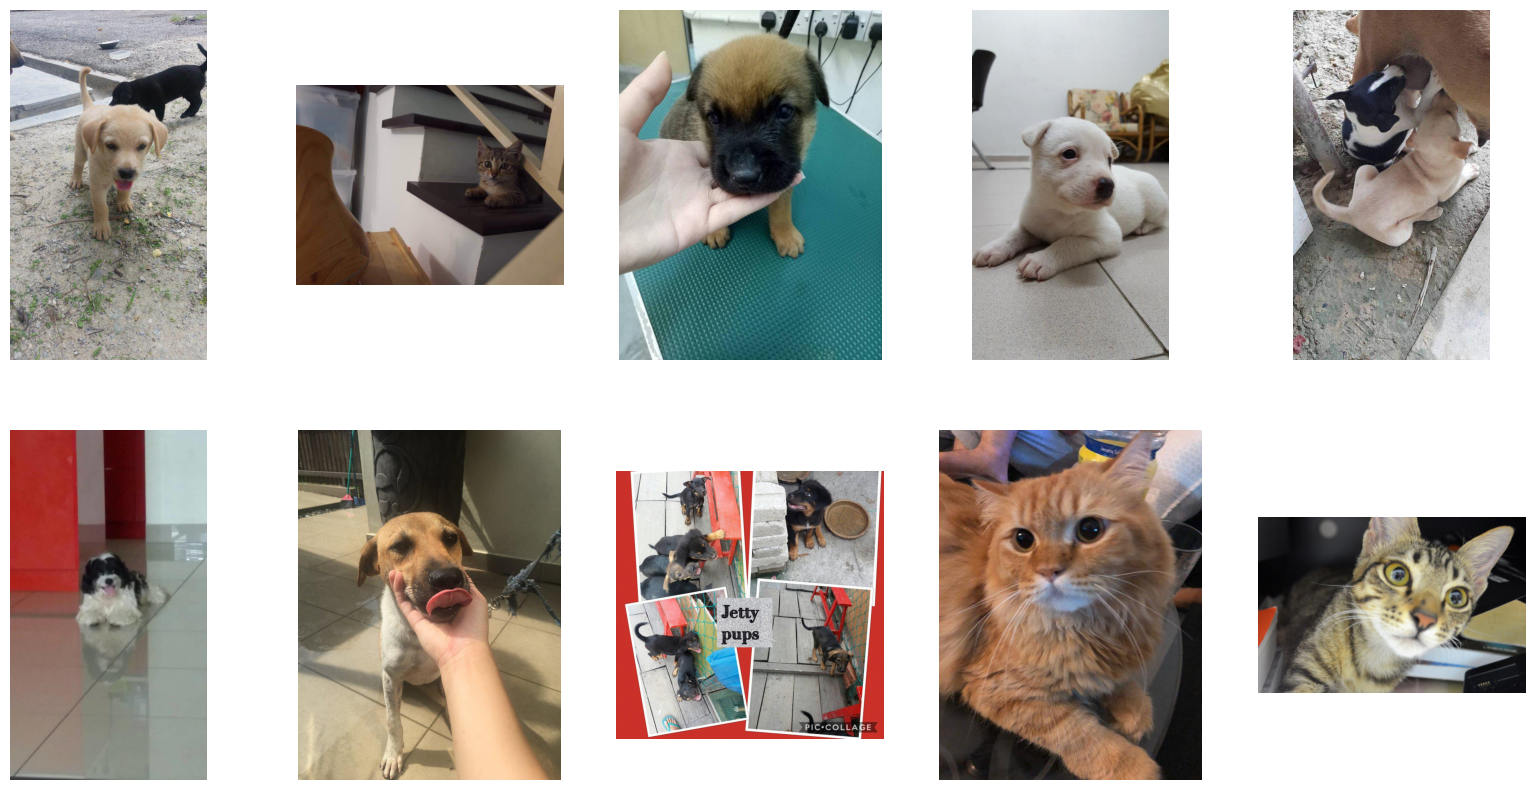

In [316]:
# Display 10 (original size) images
index=0
num_rows=2
num_cols=5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,10))
for i in range(num_rows):
    for j in range(num_cols):
        axs[i,j].imshow(cv2.cvtColor(cv_images[index], cv2.COLOR_BGR2RGB)) 
        axs[i,j].axis('off')
        index+=1
plt.show()

In [318]:
# Checking first 20 (original size) images' sizes
for i in range( len(cv_images) ):
    n_shape= np.array(cv_images[i])
    print(f"{i}" + " Image shape ", n_shape.shape)
    if i == 20:
        break

0 Image shape  (720, 405, 3)
1 Image shape  (774, 1032, 3)
2 Image shape  (960, 720, 3)
3 Image shape  (720, 405, 3)
4 Image shape  (960, 540, 3)
5 Image shape  (960, 540, 3)
6 Image shape  (960, 720, 3)
7 Image shape  (1280, 1280, 3)
8 Image shape  (960, 720, 3)
9 Image shape  (847, 1279, 3)
10 Image shape  (1280, 1280, 3)
11 Image shape  (720, 405, 3)
12 Image shape  (960, 540, 3)
13 Image shape  (960, 720, 3)
14 Image shape  (638, 581, 3)
15 Image shape  (960, 720, 3)
16 Image shape  (960, 1280, 3)
17 Image shape  (647, 648, 3)
18 Image shape  (960, 528, 3)
19 Image shape  (960, 720, 3)
20 Image shape  (569, 538, 3)


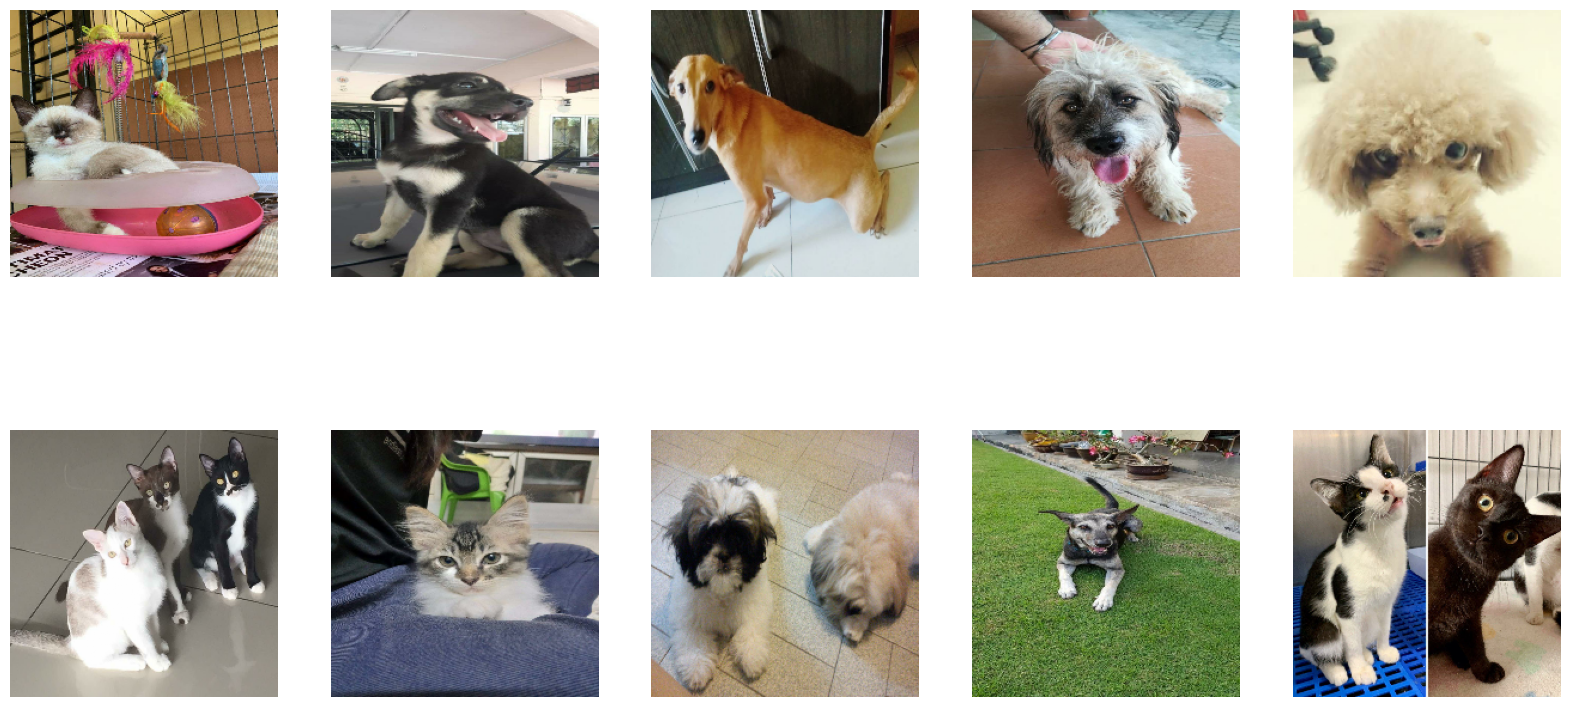

In [284]:
# Display 10 (resized) images from first batch
index=0
num_rows=2
num_cols=5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,10))
for i in range(num_rows):
    for j in range(num_cols):
        axs[i,j].imshow(train_tuples[0][0][index] / 255) 
        axs[i,j].axis('off')
        index+=1
plt.show()

In [109]:
# Checking the number of images
def num_images(tuples):
    num_imgs = 0
    for i in range(len(tuples)):
        num_imgs += len(tuples[i][0])
    return num_imgs
    
number_images = num_images(train_tuples) + num_images(val_tuples)
print("Number of images", number_images)

Number of images 9912


In [110]:
# First image and its shape in train set
print("First Image \n ",train_tuples[0][0][0])
print("First Image shape: ",train_tuples[0][0][0].shape)


First Image 
  [[[181.89285  148.89285   77.89286 ]
  [182.       149.        78.      ]
  [179.53572  146.53572   75.53571 ]
  ...
  [164.72002  148.84932   79.32398 ]
  [ 32.67352   32.76554   15.614187]
  [129.48886  105.06815   61.03106 ]]

 [[181.89285  148.89285   77.89286 ]
  [182.       149.        78.      ]
  [179.53572  146.53572   75.53571 ]
  ...
  [169.061    149.73138   77.55818 ]
  [ 73.37938   67.116714  42.85309 ]
  [ 67.7438    54.588226  13.788245]]

 [[182.       149.        78.      ]
  [182.       149.        78.      ]
  [181.46428  148.46428   77.46429 ]
  ...
  [162.8145   141.30147   65.63118 ]
  [122.51066  107.58455   73.15247 ]
  [ 46.03816   46.160366  13.880543]]

 ...

 [[194.89026  191.8673   182.8673  ]
  [197.3649   194.21948  185.21948 ]
  [199.9694   196.7398   188.92604 ]
  ...
  [199.9971   183.9971   157.9971  ]
  [206.6915   190.6915   165.98232 ]
  [171.38057  159.05904  135.5948  ]]

 [[196.4719   195.32907  190.32907 ]
  [200.94643  200.7322

In [245]:
# Checking for missing values in tabular data
print(train_df.isnull().sum())

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64


In [246]:
# Checking for duplicates in tabular data
ids = train_df['Id']
train_df[ids.isin(ids[ids.duplicated()])].sort_values('Id')

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity


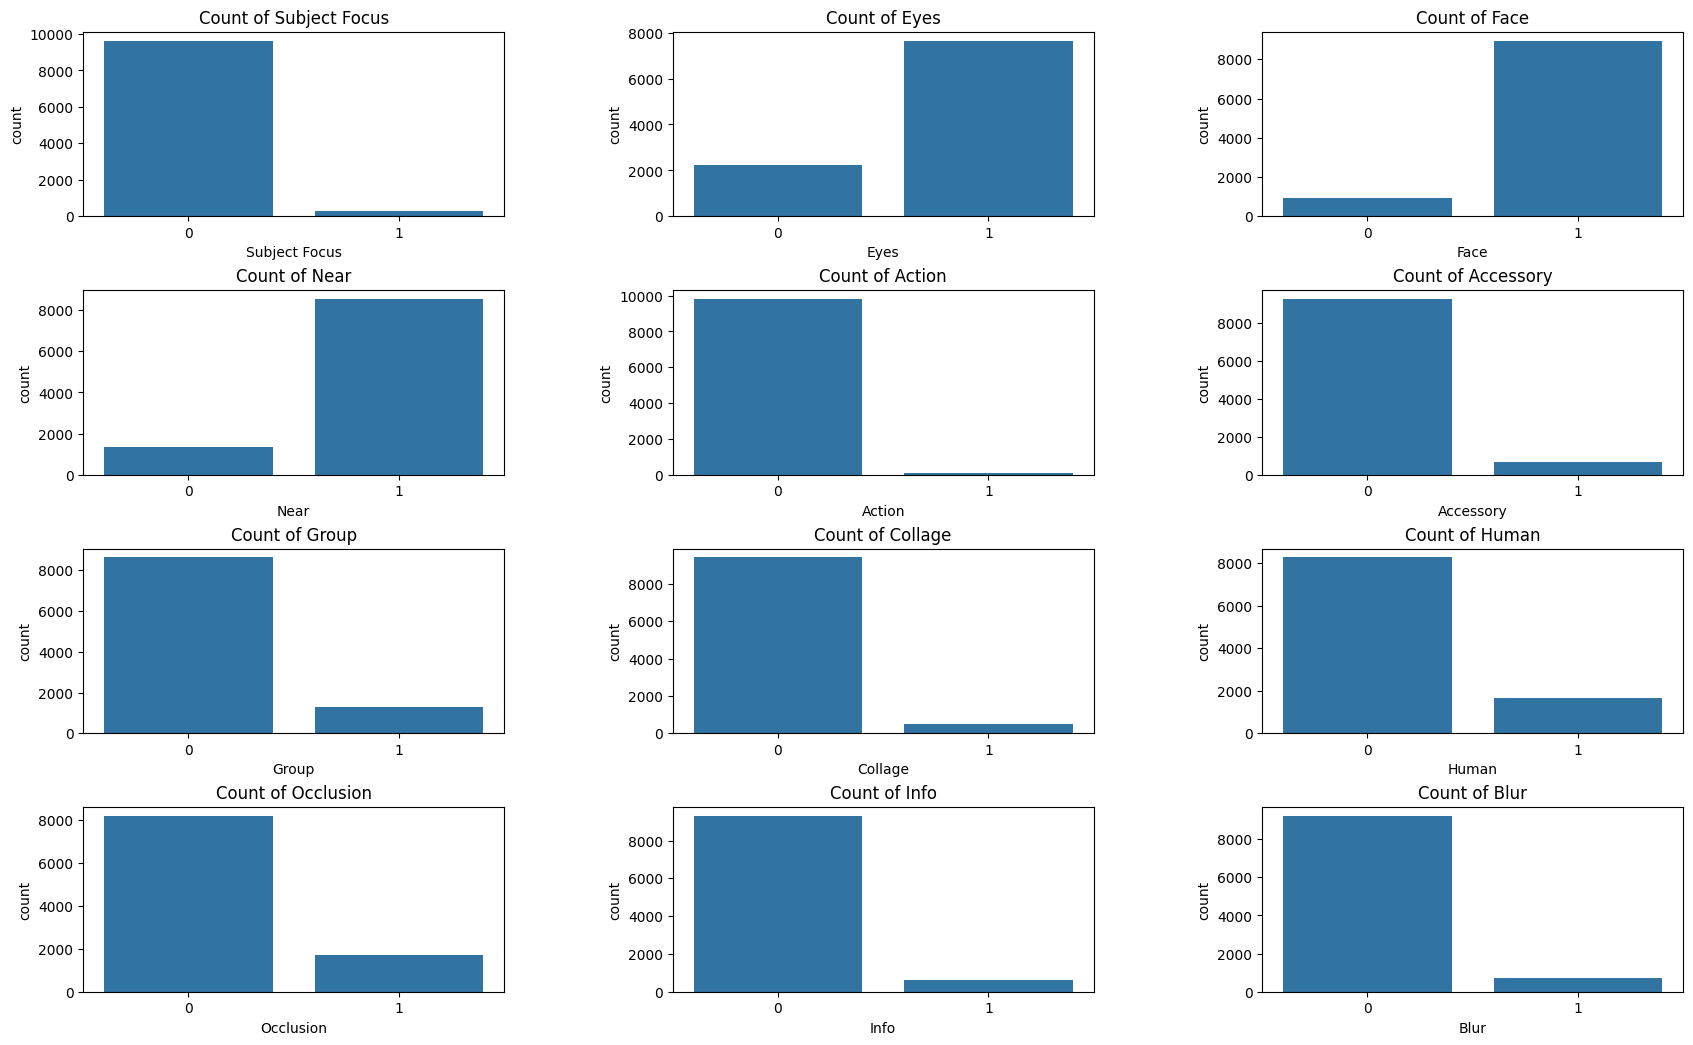

In [264]:
# Plot the count of every feature
columns= train_df.columns
i=0
j=0
k=0
fig, axs = plt.subplots(4, 3, figsize=(20,12))
for col in columns: 
    if (k < len(columns)-1) and (i!= 4):
        sns.countplot(data = train_df, x = col,ax = axs[i,j])
        axs[i,j].set_title(f'Count of {columns[k]}')
        if j==2:
            i+=1
            j=0
        else:
            j+=1
        k+=1
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()


In [247]:
# Statistics summary
train_df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


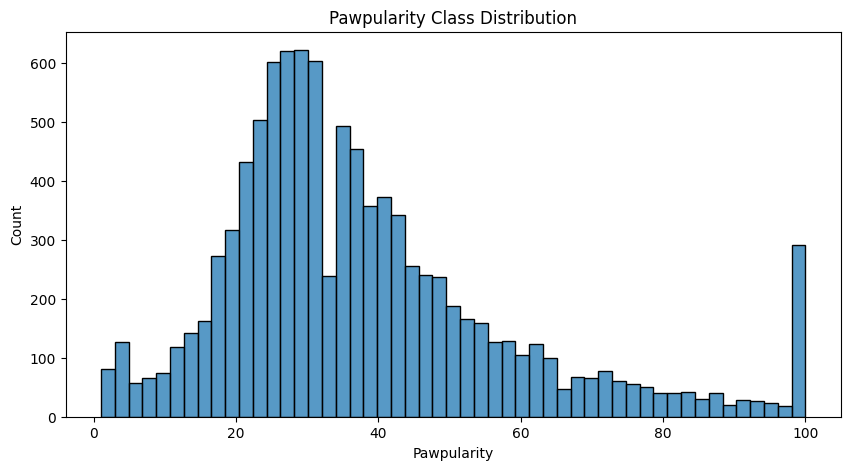

In [267]:
# Plot the target class distribution

# convert the labels array to a pandas dataframe
labels_df = pd.DataFrame(train_df['Pawpularity'], columns =['Pawpularity'])
# histogram
plt.figure(figsize=(10,5))
sns.histplot(data= labels_df, stat= 'count', x='Pawpularity')
plt.title('Pawpularity Class Distribution')
plt.xlabel("Pawpularity");

In [292]:
# Correlation of 'pawpularity' against all other features
train_df = train_df.set_index('Id')
corr_matrix = train_df.corr()['Pawpularity']
corr_matrix

Subject Focus   -0.009853
Eyes            -0.006686
Face             0.008018
Near             0.001001
Action          -0.001373
Accessory        0.013287
Group            0.016469
Collage          0.001732
Human            0.003983
Occlusion        0.001979
Info            -0.004735
Blur            -0.023540
Pawpularity      1.000000
Name: Pawpularity, dtype: float64

Text(0.5, 1.0, 'Train Correlation Heatmap')

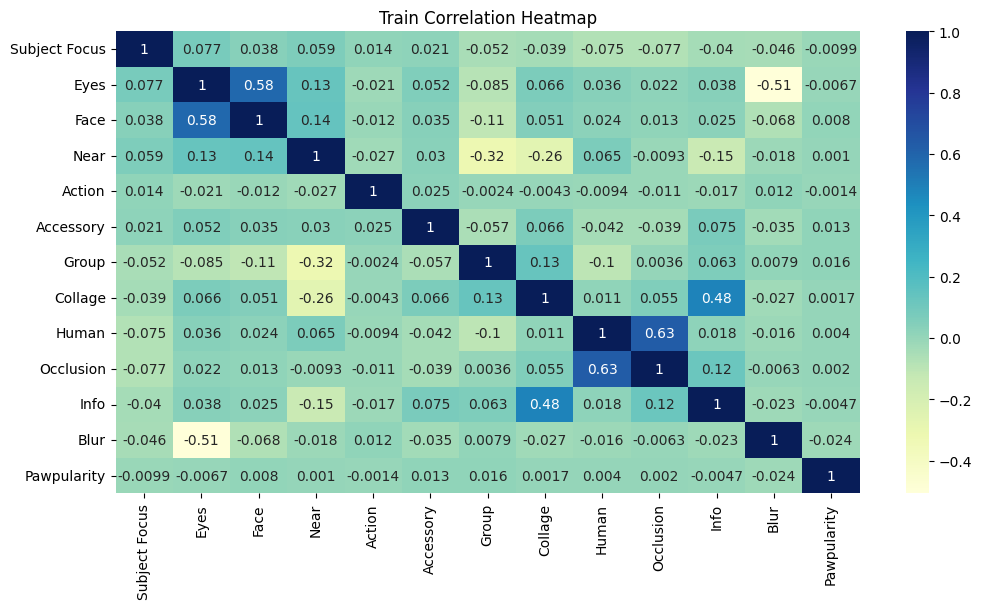

In [293]:
# Plot correlation heatmap
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(train_df.iloc[:].corr(), annot=True, cmap='YlGnBu')
heatmap.set_title('Train Correlation Heatmap')

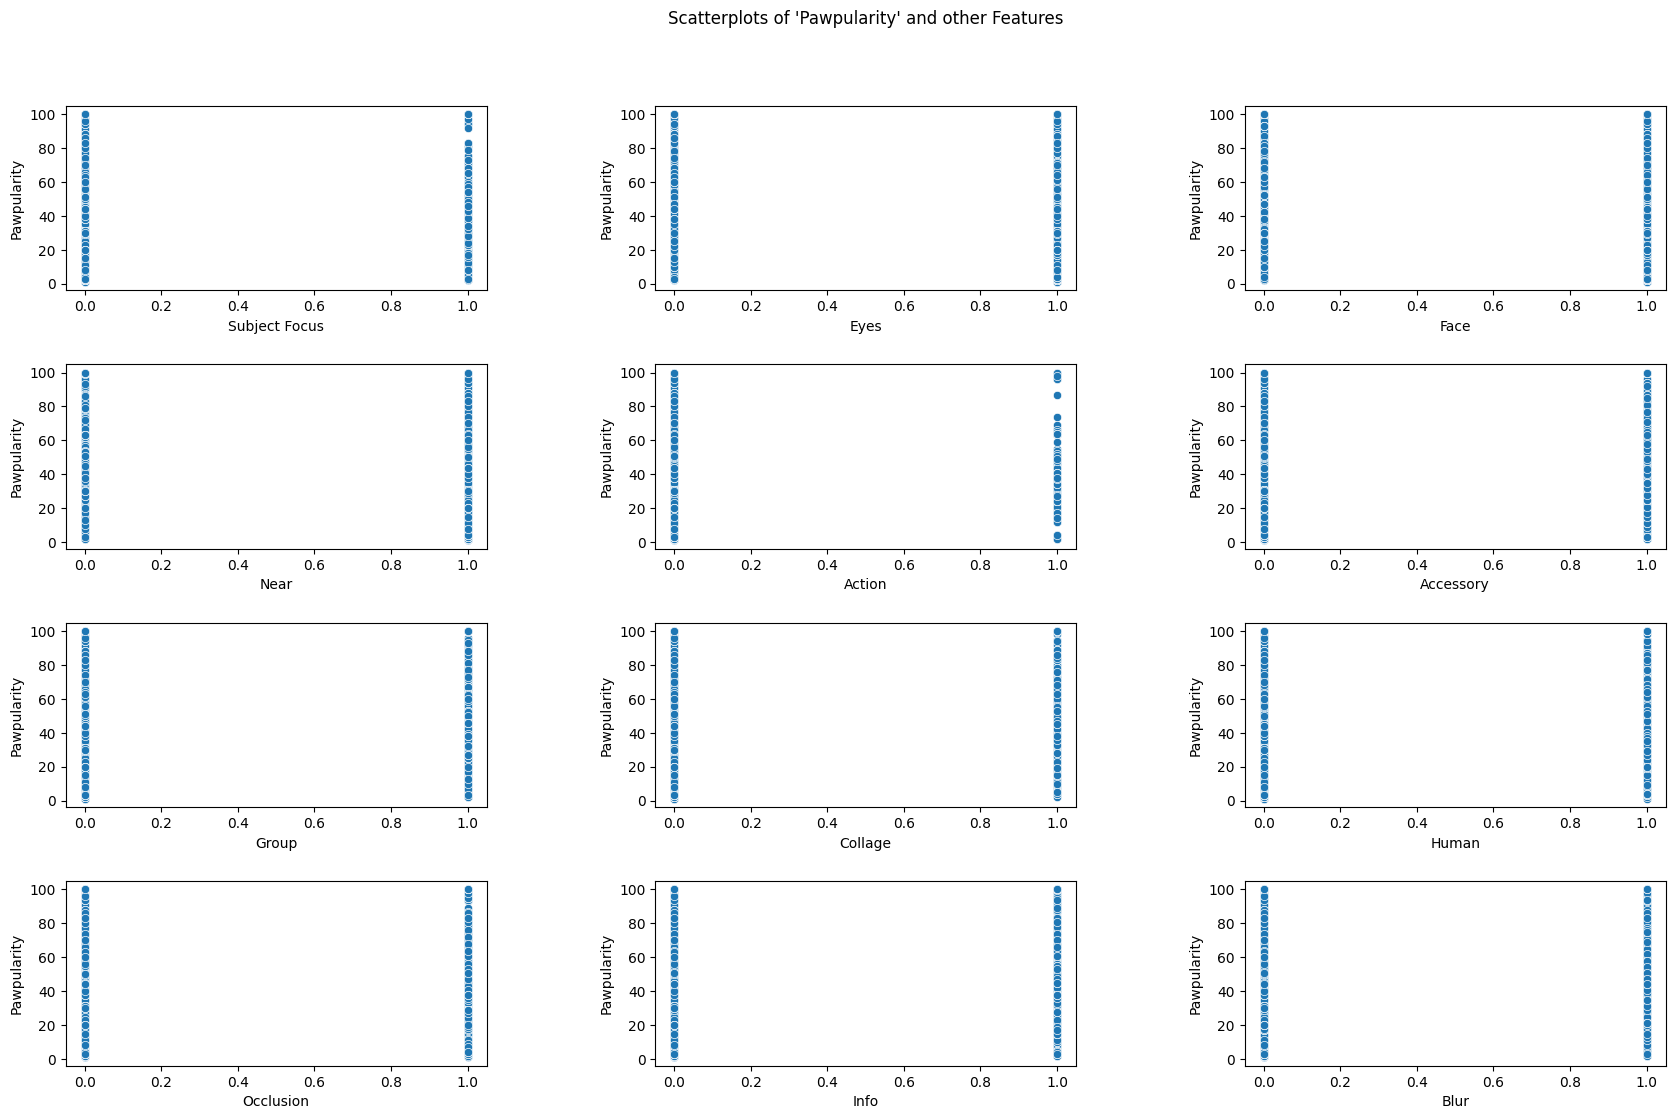

In [305]:
# Scatterplots of 'Pawpularity' and other features
columns= train_df.columns
i=0
j=0
k=0
fig, axs = plt.subplots(4, 3, figsize=(20,12))
for col in columns: 
    if (k < len(columns)-1) and (i!= 4):
        sns.scatterplot(data = train_df, x = col,y= 'Pawpularity',ax = axs[i,j])
        #axs[i,j].set_title(f'Count of {columns[k]}')
        if j==2:
            i+=1
            j=0
        else:
            j+=1
        k+=1
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.suptitle('Scatterplots of \'Pawpularity\' and other Features')
plt.show()


### Step 4: Modeling and Evaluation

### <span style="color:chocolate"> Baseline Model  </span>

### <span style="color:chocolate"> Improvement on Baseline Model  </span>

### Step 5: Interpretation

TBD